In [1]:
PROJECT_ID = "vertexaiproject-454121"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

REGION = 'us-central1'

# Model Training
VAR_TARGET = 'Class'

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

In [4]:
bq = bigquery.Client()
aiplatform.init(location = REGION)

In [5]:
query = f"""
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection` LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748.0,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074.0,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488.0,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392.0,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [6]:
query = f"""
SELECT Class, COUNT(*) as count
FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
GROUP BY Class
ORDER BY Class;

"""
bq.query(query = query).to_dataframe()

,Class,count
0,0,284315
1,1,492


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

**Hyperparameter Tuning**

The [following options](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#create_model_syntax) are added to the model training code for BQML to guide the hyperparameter tuning of `L1` and `L2` regularization:

```SQL
l1_reg = HPARAM_RANGE(0, 1000),
l2_reg = HPARAM_RANGE(0, 1000),
hparam_tuning_algorithm = 'VIZIER_DEFAULT',
hparam_tuning_objectives = ['ROC_AUC'],
num_trials = 20,
max_parallel_trials = 2
```

This instructs BQML to use the Vertex AI Vizier service to find values of `l1_reg` and `l2_reg` that optimize 'roc_auc' by doing 4 trials at a time until 20 trials have been completed.


In [7]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.dataset_name`;

CREATE OR REPLACE MODEL `{PROJECT_ID}.dataset_name.model_name`
TRANSFORM(
    * EXCEPT(Amount),
    SAFE.LOG(Amount) AS log_amount
)

OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'Time',
        data_split_method = 'seq',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 2,
        max_parallel_trials = 2
    ) AS
    
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
"""
print(query)


CREATE SCHEMA IF NOT EXISTS `vertexaiproject-454121.dataset_name`;

CREATE OR REPLACE MODEL `vertexaiproject-454121.dataset_name.model_name`
TRANSFORM(
    * EXCEPT(Amount),
    SAFE.LOG(Amount) AS log_amount
)

OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'Time',
        data_split_method = 'seq',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 2,
        max_parallel_trials = 2
    ) AS
    
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`



In [8]:
job = bq.query(query = query)
job.result()

In [9]:
query = f"""
SELECT * FROM ML.EVALUATE(MODEL `{PROJECT_ID}.dataset_name.model_name`)
"""
bq.query(query = query).to_dataframe()

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.031148,0.863636,0.979171,0.060127,0.117818,0.980979
1,2,0.031148,0.863636,0.979171,0.060127,0.117818,0.980979


In [10]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [11]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{PROJECT_ID}.dataset_name.model_name`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,V1,-56.407510,2.454930,-0.067308,-0.021297,1.943576,<NA>,0,<NA>
1,V8,-73.216718,20.007208,0.004015,0.031225,1.209550,<NA>,0,<NA>
2,V10,-24.588262,23.745136,-0.001703,-0.087897,1.093929,<NA>,0,<NA>
3,V17,-25.162799,9.253526,0.015149,-0.042549,0.874216,<NA>,0,<NA>
4,V13,-5.791881,4.569009,0.016753,-0.005594,1.019637,<NA>,0,<NA>
5,V26,-2.604551,3.517346,0.002807,-0.056830,0.486715,<NA>,0,<NA>
6,V3,-33.680984,9.382558,0.182743,0.385949,1.490413,<NA>,0,<NA>
7,V28,-11.710896,33.847808,0.001959,0.016131,0.334158,<NA>,0,<NA>
8,V21,-34.830382,27.202839,-0.006614,-0.034858,0.744550,<NA>,0,<NA>
9,V5,-42.147898,34.801666,-0.063886,-0.126963,1.373119,<NA>,0,<NA>


Retrieve the trial info for the hyperparameter tuning trials with [ML.TRIAL_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-trial-info):

In [12]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{PROJECT_ID}.dataset_name.model_name`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1e-14}",{'roc_auc': 0.9876993006993007},0.11831,0.121665,SUCCEEDED,None,True
1,2,"{'l1_reg': 5.459753572979378e-11, 'l2_reg': 5....",{'roc_auc': 0.9876993006993007},0.11831,0.121665,SUCCEEDED,None,True


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [13]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    )
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,1,0,278779,5536
1,1,1,45,447


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [14]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    )
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1,1.000000,0.024390,0.000000,12,0,284315,480
1,1,0.681256,0.886179,0.008726,436,2481,281834,56
2,1,0.512484,0.908537,0.018388,447,5228,279087,45
3,1,0.418019,0.914634,0.028532,450,8112,276203,42
4,1,0.355482,0.926829,0.038939,456,11071,273244,36


---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [15]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{PROJECT_ID}.dataset_name.model_name`,(
    SELECT *
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    ), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [16]:
explain.head()

,trial_id,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0,0.887093,"[{'feature': 'V4', 'attribution': 0.4993371321...",-2.702384,-2.061382,0.0,282.0,-0.356466,0.725418,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
1,1,0,0.875916,"[{'feature': 'V4', 'attribution': 1.7769435137...",-2.702384,-1.954312,0.0,14332.0,1.071950,0.340678,...,-0.169632,-0.113604,0.067643,0.468669,0.223541,-0.112355,0.014015,0.021504,0.0,0
2,1,0,0.837609,"[{'feature': 'V4', 'attribution': 0.9109991751...",-2.702384,-1.640541,0.0,32799.0,1.153477,-0.047859,...,0.125514,0.480049,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0
3,1,0,0.938791,"[{'feature': 'V14', 'attribution': -0.63741266...",-2.702384,-2.730295,0.0,35799.0,-0.769798,0.622325,...,0.152738,0.255654,-0.130237,-0.660934,-0.493374,0.331855,-0.011101,0.049089,0.0,0
4,1,0,0.811874,"[{'feature': 'V4', 'attribution': 1.8316327244...",-2.702384,-1.462236,0.0,36419.0,1.047960,0.145048,...,0.078499,0.658942,-0.067810,0.476882,0.526830,0.219902,0.070627,0.028488,0.0,0


Create a plot of feature attributions for a single prediction:

In [17]:
explanation = explain.iloc[0]['top_feature_attributions']

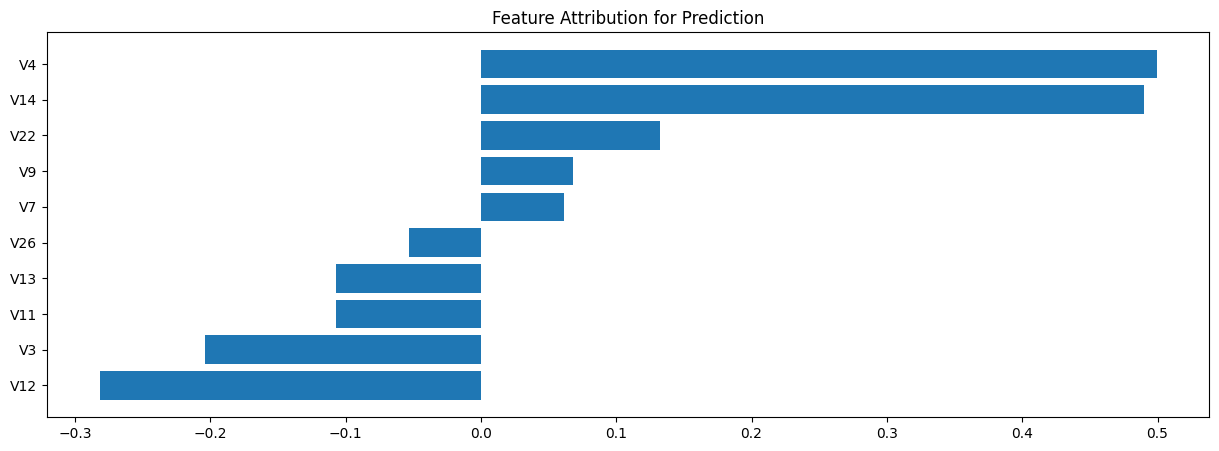

In [18]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [19]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{PROJECT_ID}.dataset_name.model_name`)
"""

gexplain = bq.query(query = query).to_dataframe()

In [20]:
gexplain.head()

,trial_id,feature,attribution
0,1,V4,0.682012
1,1,V14,0.461570
2,1,V12,0.356620
3,1,V10,0.255958
4,1,V16,0.215227


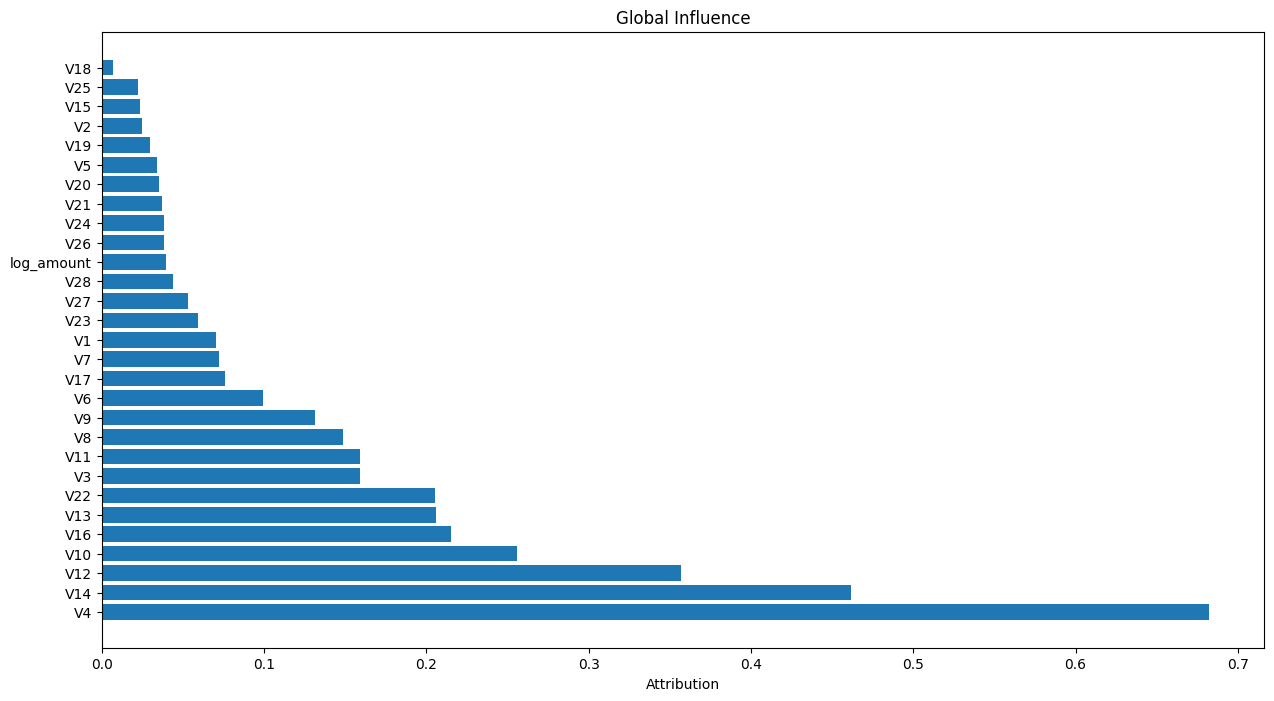

In [21]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()